This notebook reproduces the first experiment in the BatchNorm [paper](http://proceedings.mlr.press/v37/ioffe15.pdf) to inspect more closely the effect that BN has on the training dynamics of neural networks. The authors studied a rather simple network (MLP with three hidden layers and sigmoid activation function) trained on MNIST.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.datasets import MNIST

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
class CacheMNIST(Dataset):

    def __init__(self, train=True):
        super(CacheMNIST, self).__init__()
        self.cache = {}
        self.dataset = MNIST(root='./', train=train, transform=T.ToTensor(), download=True)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        # Since MNIST is a rather small dataset,
        # we cacahe it to memory in the first run to accelerate later epochs.
        if index in self.cache:
            return self.cache[index]

        self.cache[index] = self.dataset[index]
        return self.__getitem__(index)

In [3]:
class MNIST_MLP(nn.Module):

    def __init__(self, num_hidden=3, activation='Sigmoid', use_bn=True):
        super(MNIST_MLP, self).__init__()
        bn_module = nn.BatchNorm1d if use_bn else nn.Identity
        act_module = getattr(nn, activation)

        self.layers = nn.ModuleList()
        for ix in range(num_hidden):
            in_features = 28*28 if ix == 0 else 100
            self.layers.append(nn.Sequential(
                nn.Linear(in_features, 100),
                # BN is applied immediately after linear to modify only the first and second moments.
                bn_module(100),
                act_module()
            ))

        self.clf = nn.Linear(100, 10)

        # Keep record of the inputs to the activation functions.
        self.act_inputs = [[] for _ in range(num_hidden)]

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for ix, layer in enumerate(self.layers):
            self.act_inputs[ix].append(x.detach().mean().cpu().numpy())
            x = layer(x)

        return self.clf(x)

    def plot_activation_input(self):
        for ix, input in enumerate(self.act_inputs):
            plt.plot(input, label=f'Layer {ix+1}')

        plt.legend()
        plt.show()

In [4]:
def train_mnist(model, optimizer, device='cuda'):
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(CacheMNIST(train=True), batch_size=60, shuffle=True)
    test_loader = DataLoader(CacheMNIST(train=False), batch_size=60)

    # Train for 50000 steps, with 60 examples per mini-batch.
    num_epochs = 50000 // (len(train_loader.dataset) // train_loader.batch_size)
    for epoch in range(num_epochs):
        train_loss = []
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        with torch.no_grad():
            test_true, test_pred = [], []
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)

                logits = model(x)
                test_true.append(y.cpu().numpy())
                test_pred.append(logits.argmax(dim=-1).cpu().numpy())

            test_true = np.concatenate(test_true)
            test_pred = np.concatenate(test_pred)

        train_loss = np.mean(train_loss)
        test_acc = accuracy_score(test_true, test_pred)

        if epoch % 5 == 0 or epoch+1 == num_epochs:
            print(f'Epoch {epoch+1}/{num_epochs} | Loss {"%.3f" % train_loss} | Acc {"%.3f" % test_acc}')

First, lets train the network without BN and plot the input distributions to the activation function.

Epoch 1/50 | Loss 2.312 | Acc 0.114
Epoch 6/50 | Loss 2.301 | Acc 0.114
Epoch 11/50 | Loss 2.301 | Acc 0.114
Epoch 16/50 | Loss 2.301 | Acc 0.114
Epoch 21/50 | Loss 2.301 | Acc 0.114
Epoch 26/50 | Loss 2.301 | Acc 0.114
Epoch 31/50 | Loss 2.301 | Acc 0.114
Epoch 36/50 | Loss 2.301 | Acc 0.114
Epoch 41/50 | Loss 2.301 | Acc 0.114
Epoch 46/50 | Loss 2.301 | Acc 0.114
Epoch 50/50 | Loss 2.301 | Acc 0.114


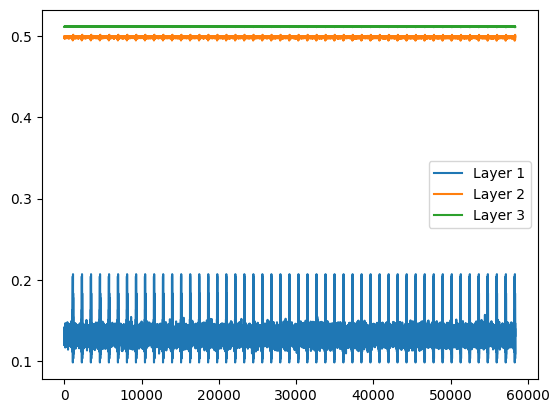

In [5]:
model = MNIST_MLP(num_hidden=3, activation='Sigmoid', use_bn=False)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
train_mnist(model, optimizer, device='cuda')
model.plot_activation_input()

It's quite suprising that the network failed to train at all and produces almost the same prediction for all data (given the simplicity of the task we're dealing with). Let's first try to reduce the number of layers in our network.

In [6]:
model = MNIST_MLP(num_hidden=1, activation='Sigmoid', use_bn=False)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
train_mnist(model, optimizer, device='cuda')

Epoch 1/50 | Loss 2.295 | Acc 0.126
Epoch 6/50 | Loss 2.144 | Acc 0.546
Epoch 11/50 | Loss 1.894 | Acc 0.654
Epoch 16/50 | Loss 1.556 | Acc 0.723
Epoch 21/50 | Loss 1.253 | Acc 0.769
Epoch 26/50 | Loss 1.037 | Acc 0.799
Epoch 31/50 | Loss 0.890 | Acc 0.819
Epoch 36/50 | Loss 0.786 | Acc 0.834
Epoch 41/50 | Loss 0.711 | Acc 0.845
Epoch 46/50 | Loss 0.654 | Acc 0.856
Epoch 50/50 | Loss 0.618 | Acc 0.861


We can see that the simpler network trains smoothly and is already quite accurate on this dataset. We here observe the degeneration problem, which is the main focus of the ResNet [paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7780459). Meanwhile, it is well-acknowledged that sigmoid networks are hard to train due to saturating activations and vanishing gradients. Let's switch the activation function to ReLU.

In [7]:
model = MNIST_MLP(num_hidden=3, activation='ReLU', use_bn=False)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
train_mnist(model, optimizer, device='cuda')

Epoch 1/50 | Loss 2.302 | Acc 0.121
Epoch 6/50 | Loss 2.252 | Acc 0.470
Epoch 11/50 | Loss 1.721 | Acc 0.570
Epoch 16/50 | Loss 0.812 | Acc 0.796
Epoch 21/50 | Loss 0.523 | Acc 0.860
Epoch 26/50 | Loss 0.421 | Acc 0.885
Epoch 31/50 | Loss 0.375 | Acc 0.895
Epoch 36/50 | Loss 0.348 | Acc 0.902
Epoch 41/50 | Loss 0.328 | Acc 0.909
Epoch 46/50 | Loss 0.312 | Acc 0.914
Epoch 50/50 | Loss 0.300 | Acc 0.916


We can clearly see that ReLU is doing a good job here. In fact, there exist many other methods to train deeper networks well, like using residual connections and the [Adam](https://arxiv.org/pdf/1412.6980.pdf) optimizer. Now we move on to further debug our not-so-deep sigmoid network by looking at the gradients.

In [8]:
def hook(module, grad_input, grad_output):
    # Compute local gradient of the activation layer.
    grad_local = grad_input[0] / grad_output[0]
    print(torch.min(torch.abs(grad_local)))


model = MNIST_MLP(num_hidden=3, activation='Sigmoid', use_bn=False)
for ix in range(len(model.layers)):
    model.layers[ix][2].register_backward_hook(hook)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
train_mnist(model, optimizer, device='cuda')

tensor(0.2180, device='cuda:0')
tensor(0.2070, device='cuda:0')
tensor(0.2139, device='cuda:0')
tensor(0.2179, device='cuda:0')
tensor(0.2073, device='cuda:0')
tensor(0.2107, device='cuda:0')
tensor(0.2181, device='cuda:0')
tensor(0.2068, device='cuda:0')
tensor(0.1927, device='cuda:0')
tensor(0.2179, device='cuda:0')
tensor(0.2084, device='cuda:0')
tensor(0.2055, device='cuda:0')
tensor(0.2180, device='cuda:0')
tensor(0.2088, device='cuda:0')
tensor(0.2014, device='cuda:0')
tensor(0.2180, device='cuda:0')
tensor(0.2069, device='cuda:0')
tensor(0.1945, device='cuda:0')
tensor(0.2179, device='cuda:0')
tensor(0.2068, device='cuda:0')
tensor(0.2019, device='cuda:0')
tensor(0.2179, device='cuda:0')
tensor(0.2064, device='cuda:0')
tensor(0.2065, device='cuda:0')
tensor(0.2179, device='cuda:0')
tensor(0.2069, device='cuda:0')
tensor(0.1864, device='cuda:0')
tensor(0.2178, device='cuda:0')
tensor(0.2097, device='cuda:0')
tensor(0.1904, device='cuda:0')
tensor(0.2178, device='cuda:0')
tensor(0

Here it doesn't show any sign of saturation. In fact, the activations are in the linear regions of sigmoid. For this case, the difficulity of training sigmoid networks seems to originate from other sources. Finally, let apply BN to the layers.

Epoch 1/50 | Loss 2.024 | Acc 0.722
Epoch 6/50 | Loss 1.099 | Acc 0.878
Epoch 11/50 | Loss 0.769 | Acc 0.898
Epoch 16/50 | Loss 0.604 | Acc 0.907
Epoch 21/50 | Loss 0.506 | Acc 0.914
Epoch 26/50 | Loss 0.443 | Acc 0.918
Epoch 31/50 | Loss 0.395 | Acc 0.923
Epoch 36/50 | Loss 0.354 | Acc 0.926
Epoch 41/50 | Loss 0.320 | Acc 0.932
Epoch 46/50 | Loss 0.288 | Acc 0.938
Epoch 50/50 | Loss 0.265 | Acc 0.942


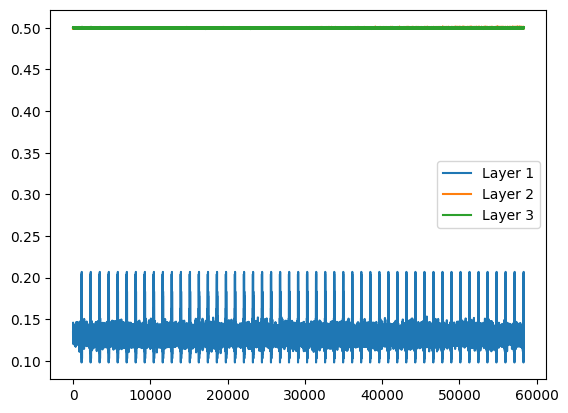

In [9]:
model = MNIST_MLP(num_hidden=3, activation='Sigmoid', use_bn=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
train_mnist(model, optimizer, device='cuda')
model.plot_activation_input()

BN accelatrates training and yields the best result. (The activation inputs don't seem right...)